# Análise Dados de Crime

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

### Funções

In [2]:
def processar_ficheiro(caminho_ficheiro, header=4, pasta_saida='.'):
    
    df = pd.read_excel(caminho_ficheiro, header=header)
    
    df.columns = df.columns.map(str).str.strip()

    if len(df.columns) >= 2:
        df.columns.values[0] = 'local'
        df.columns.values[1] = 'codigo'

    df = df.loc[:, ~df.columns.str.startswith('Unnamed')]
    df = df[~df.iloc[:, 1:].isna().all(axis=1)]
    df = df.fillna(0)
    
    return df


In [3]:

def carregar_municipios(df):
    df['codigo'] = df['codigo'].astype(str)
    df_municipios = df[df['codigo'].str.match(r'^\d{7}$')].copy()
    return df_municipios

In [4]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy as np

def aplicar_kmeans(df, n_clusters=3, nome_cluster='cluster'):
    dados_numericos = df.drop(columns=['local', 'codigo'])
    scaler = StandardScaler()
    dados_escalados = scaler.fit_transform(dados_numericos)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(dados_escalados)

    centroides = kmeans.cluster_centers_
    ordem = np.argsort(centroides[:, 0]) 
    mapeamento = {old: new for new, old in enumerate(ordem)}
    labels_ordenados = np.vectorize(mapeamento.get)(labels)

    df[nome_cluster] = labels_ordenados

    pca = PCA(n_components=2)
    reduzido = pca.fit_transform(dados_escalados)
    df['PCA1'] = reduzido[:, 0]
    df['PCA2'] = reduzido[:, 1]

    print(df[nome_cluster].value_counts().sort_index())

    return df


In [5]:
def plotar_clusters(df, cluster_col, titulo='Clusters'):
    fig = px.scatter(
        df, x='PCA1', y='PCA2',
        color=cluster_col,
        hover_data=['local', 'Total', cluster_col],
        title=titulo,
    )
    fig.show()

### Análise do Número de Crimes

In [6]:
df_crimes = processar_ficheiro('/Users/joaopino/Principal/2Semester/ADE/project/data/dados_municipio/Crime (2)/Crimes registados .xls',4)
df_crimes_municipios = carregar_municipios(df_crimes)
print(df_crimes_municipios.shape)
# df_crimes_municipios = aplicar_kmeans(df_crimes_municipios, n_clusters=3, nome_cluster='cluster_num_crimes')
# df_crimes_municipios
# plotar_clusters(df_crimes_municipios, 'cluster_num_crimes', titulo='Clusters de Número de Crimes')



(147, 18)


### Análise da Taxa de Criminalidade

In [7]:
df_taxa_criminalidade = processar_ficheiro('./Taxa de criminalidade.xls',4)
df_taxa_criminalidade_municipios = carregar_municipios(df_taxa_criminalidade)
df_taxa_criminalidade_municipios = aplicar_kmeans(df_taxa_criminalidade_municipios, n_clusters=3, nome_cluster='cluster_taxa_crime')
plotar_clusters(df_taxa_criminalidade_municipios, 'cluster_taxa_crime', titulo='Clusters de Taxa de Criminalidade')


FileNotFoundError: [Errno 2] No such file or directory: './Taxa de criminalidade.xls'

### Análise Geral

In [ ]:
df_cluster_crime = pd.merge(
    df_taxa_criminalidade_municipios[['codigo', 'local', 'cluster_taxa_crime']],
    df_crimes_municipios[['codigo', 'cluster_num_crimes']],
    on='codigo',
    how='inner'
)

print(df_cluster_crime.head())

    codigo              local  cluster_taxa_crime  cluster_num_crimes
0  1111601  Arcos de Valdevez                   1                   0
1  1111602            Caminha                   1                   0
2  1111603            Melgaço                   1                   0
3  1111604             Monção                   0                   0
4  1111605   Paredes de Coura                   1                   0


/Users/mariainesfernandes/anaconda3/lib/python3.11/site-packages/sklearn/base.py:1389: ConvergenceWarning:

Number of distinct clusters (9) found smaller than n_clusters (10). Possibly due to duplicate points in X.



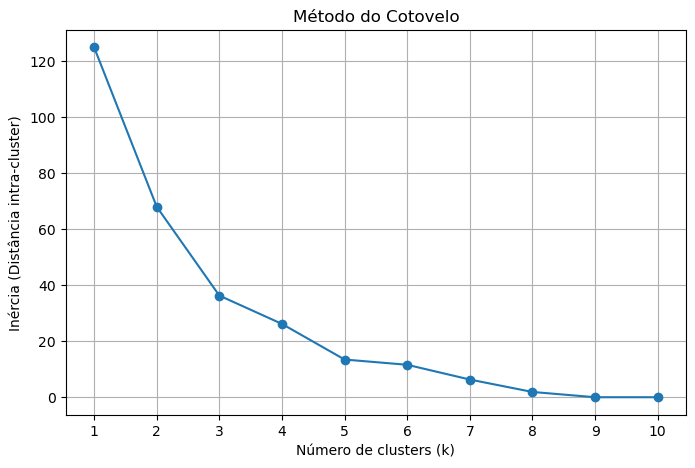

In [ ]:
X_meta = df_cluster_crime[['cluster_taxa_crime', 'cluster_num_crimes']]

inercia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_meta)
    inercia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inercia, marker='o')
plt.title('Método do Cotovelo')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inércia (Distância intra-cluster)')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [ ]:
X_meta = df_cluster_crime[['cluster_taxa_crime', 'cluster_num_crimes']]

kmeans_meta = KMeans(n_clusters=3, random_state=42, n_init='auto')
df_cluster_crime['cluster_global'] = kmeans_meta.fit_predict(X_meta)

fig = px.scatter(
    df_cluster_crime,
    x='cluster_taxa_crime',
    y='cluster_num_crimes',
    color='cluster_global',
    hover_data=['local', 'codigo'],
    title='Cluster Global com base nos clusters de Taxa e Número de Crimes'
)
fig.show()
print(df_cluster_crime['cluster_global'].value_counts().sort_index())


cluster_global
0    64
1    70
2    13
Name: count, dtype: int64
